In [1]:
!pip install pycocotools

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import os
from traffic_dataset import TrafficDataset
import os
import random
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
from matplotlib import patches, text, patheffects
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [3]:
conversion_label = {1:'bicycle', 2:'bus', 3:'car', 4:'motorbike', 5:'person'}

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 6  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [5]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [6]:
valid_index = []
index=0
base_dir='D:/traffic/traffic_data/traffic_data/train/labels'
for filename in list(sorted(os.listdir(base_dir))):
    if os.stat(os.path.join(base_dir, filename)).st_size == 0:
        pass
    else:
        valid_index.append(index)
    index = index + 1

In [8]:
def show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img.permute(1, 2, 0))
  return ax

def plot_img_with_bb(img, bboxes, labels, ax=None, figsize=(7,11)):
  ax = show(img, ax=ax)
  for i in range(len(bboxes)):
    bb = bboxes[i]
    ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2]-bb[0], bb[3]-bb[1], fill=False, edgecolor='red', lw=2))
    ax.text(bb[0],(bb[1]-img.shape[0]),conversion_label[labels[i].item()],verticalalignment='top',color='white',fontsize=10,weight='bold')

def visualize_data(row, column, ds, figsize):
  random.shuffle(valid_index)
  fig, ax = plt.subplots(row, column, figsize=figsize)
  plt.subplots_adjust(wspace=0.1, hspace=0)
  fig.tight_layout()
  count = 0
  for i in range(row):
    for j in range(column):
      ind = valid_index[count]
      img, targets = ds[ind]
      labels, bboxes = targets["labels"], targets["boxes"]
      plot_img_with_bb(img, bboxes, labels, ax=ax[i][j])
      count = count + 1

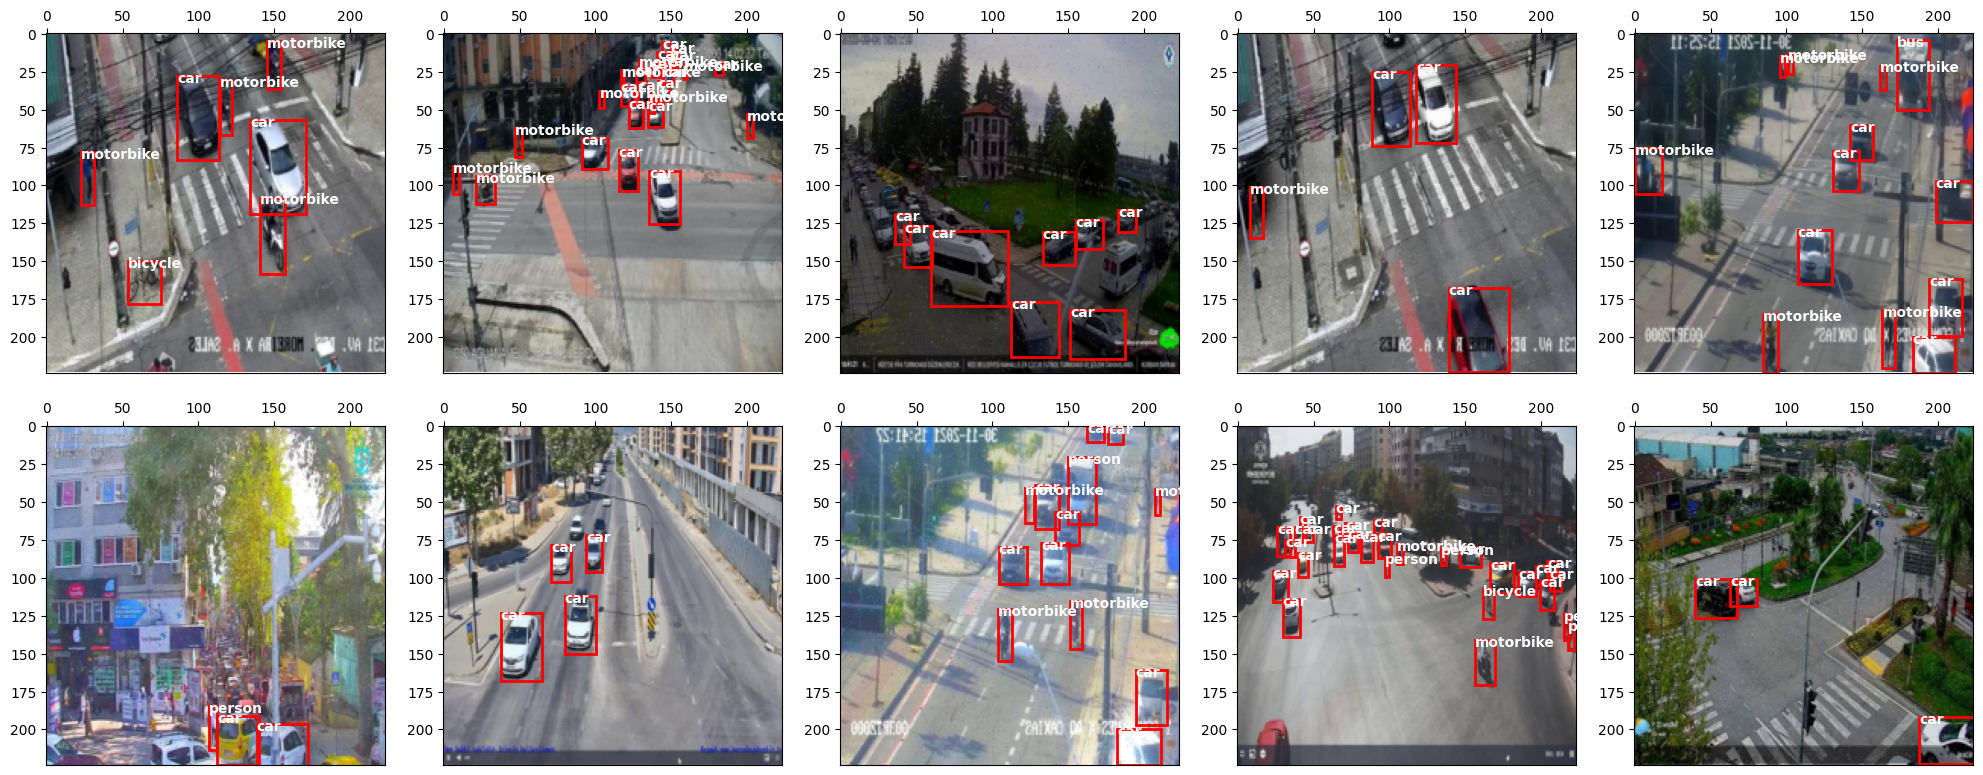

In [9]:
dataset = TrafficDataset('D:/traffic/traffic_data/traffic_data/train', get_transform(train=True), valid_index)
visualize_data(2, 5, dataset, figsize=(20,8))

In [10]:
import numpy as np


def my_collate(batch):
    len_batch = len(batch) # original batch length
    batch = list(filter (lambda x:x is not None, batch)) # filter out all the Nones
    if len_batch > len(batch):
        diff = len_batch - len(batch)
        for i in range(diff):
            random_data = dataset[valid_index[np.random.randint(0, len(valid_index)-1)]]
            if random_data is None:
                random_data = dataset[valid_index[np.random.randint(0, len(valid_index)-1)]]
            batch.append(random_data)
    return tuple(zip(*batch))
#     return utils.collate_fn(batch)

In [11]:
def evaluate(model, data_loader_test, device):
    preds_single = []
    targets_single = []

    for batch_idx, (images, targets) in enumerate(data_loader_test, 1):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        targets_single.extend(targets)

        model.eval()
        with torch.no_grad():
            pred = model(images)

        preds_single.extend(pred)

    metric.update(preds_single, targets_single)
    batch_map = metric.compute()
    val_loss_values.append(batch_map)
    print(f"Val mAP: {batch_map['map']}")

In [12]:
import torch
# import utils
import functools

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 6
# use our dataset and defined transformations
dataset = TrafficDataset('D:/traffic/traffic_data/traffic_data/train', get_transform(train=True), valid_index)
# dataset_test = TrafficDataset('/kaggle/input/traffic-detection-project/test', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-1740])
dataset_test = torch.utils.data.Subset(dataset, indices[-1740:])
# dataset_train = torch.utils.data.Subset(dataset, indices[:500])
# dataset_test = torch.utils.data.Subset(dataset, indices[501:601])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    collate_fn=my_collate
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    collate_fn=my_collate
)

In [13]:
import time
from torchmetrics.detection.mean_ap import MeanAveragePrecision

metric = MeanAveragePrecision()

# Define the lists to store the loss values for training and validation
train_loss_values = []
val_loss_values = []

def train(model, optimizer, data_loader, device, epoch, print_freq=100):
    time_start = time.time()
    loss_accum = 0.0
    loss_classifier_accum = 0.0
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader, 1):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_accum += loss.item()
        loss_classifier_accum += loss_dict['loss_classifier'].item()

        if batch_idx % print_freq == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}.")

    lr_scheduler.step()
    train_loss = loss_accum / n_batches
    train_loss_values.append(train_loss)
    train_loss_classifier = loss_classifier_accum / n_batches

    elapsed = time.time() - time_start

#     torch.save(model.state_dict(), f"pytorch_model-e{epoch}.pth")
    prefix = f"[Epoch {epoch:2d} / {num_epochs:2d}]"
    print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')

In [15]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.1
)
n_batches, n_batches_test = len(data_loader), len(data_loader_test)
num_epochs = 30

for epoch in range(num_epochs):
    curr_lr_rate = optimizer.param_groups[0]["lr"]
    print(f"Starting epoch {epoch} of {num_epochs} with lr {curr_lr_rate}")
    train(model, optimizer, data_loader, device, epoch, print_freq=500)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

Starting epoch 0 of 30 with lr 0.005
    [Batch 500 / 1017] Batch train loss:   0.504.
    [Batch 1000 / 1017] Batch train loss:   0.472.
[Epoch  0 / 30] Train loss:   0.535 [469 secs] | Val mAP: 0.4618052840232849
Starting epoch 1 of 30 with lr 0.005
    [Batch 500 / 1017] Batch train loss:   0.483.
    [Batch 1000 / 1017] Batch train loss:   0.473.
[Epoch  1 / 30] Train loss:   0.430 [464 secs] | Val mAP: 0.4925377666950226
Starting epoch 2 of 30 with lr 0.005
    [Batch 500 / 1017] Batch train loss:   0.440.
    [Batch 1000 / 1017] Batch train loss:   0.354.
[Epoch  2 / 30] Train loss:   0.379 [463 secs] | Val mAP: 0.5188779234886169
Starting epoch 3 of 30 with lr 0.005
    [Batch 500 / 1017] Batch train loss:   0.222.
    [Batch 1000 / 1017] Batch train loss:   0.184.
[Epoch  3 / 30] Train loss:   0.343 [463 secs] | Val mAP: 0.539035439491272
Starting epoch 4 of 30 with lr 0.005
    [Batch 500 / 1017] Batch train loss:   0.305.
    [Batch 1000 / 1017] Batch train loss:   0.401.
[Ep

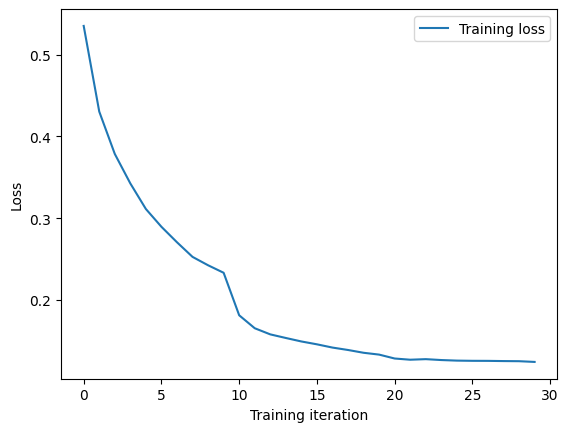

In [16]:
# Plot the loss values for training and validation using Matplotlib
plt.plot(train_loss_values, label='Training loss')
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def apply_nms(prediction, threshold):
    # torchvision returns the indices of the boxes to keep
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], threshold)

    final_prediction = prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# Function to convert a torch tensor to a PIL Image
def tensorToPIL(img):
    return torchvision.transforms.ToPILImage()(img).convert('RGB')

In [18]:
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor):
        img = torchvision.transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)

    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()

    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'b',
                                 facecolor = 'none')
        a.add_patch(rect)

    plt.show()
    print("Total number of rectangle: ", len(boxes))

predicted #boxes:  19
real #boxes:  14
EXPECTED OUTPUT



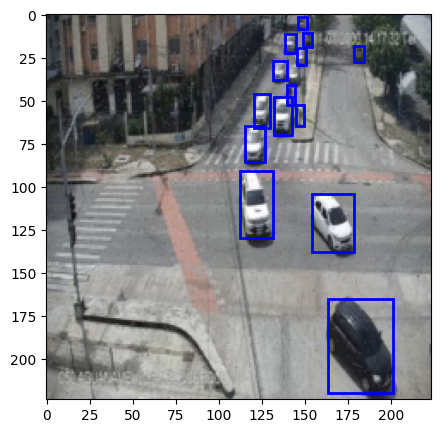

Total number of rectangle:  14
MODEL OUTPUT before NMS



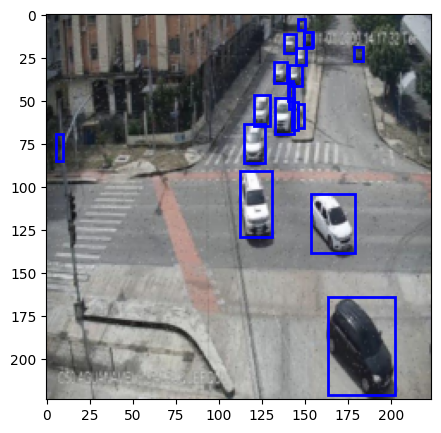

Total number of rectangle:  19
MODEL OUTPUT after NMS

predicted post nms #boxes2:  17


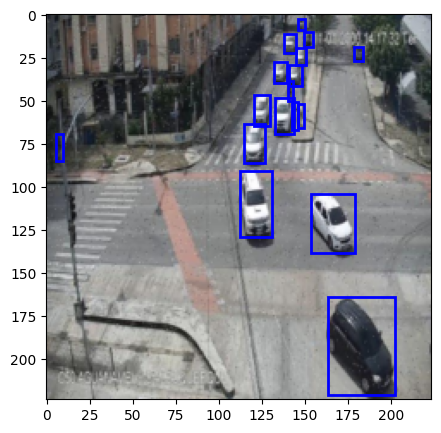

Total number of rectangle:  17


In [19]:
# pick one image from the test set
img, target = dataset_test[25]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

print('EXPECTED OUTPUT\n')
plot_img_bbox(tensorToPIL(img), target)
print('MODEL OUTPUT before NMS\n')
plot_img_bbox(tensorToPIL(img), prediction)
print('MODEL OUTPUT after NMS\n')
nms_prediction = apply_nms(prediction, threshold=0.3)
print('predicted post nms #boxes2: ', len(nms_prediction['labels']))
plot_img_bbox(tensorToPIL(img), nms_prediction)

In [21]:
torch.save(model.state_dict(), f"model.pt")